# Regression Modeling, Part 1

This lesson is adapted from a few sources: 

- The statsmodels tutorials: http://statsmodels.sourceforge.net/
- General Assembly's Data Science Course: https://github.com/justmarkham/DAT4 
- Urban Informatics and Visualization Course: https://github.com/waddell/urban-informatics-and-visualization


### Motivation

Why are we learning linear regression? 

It gives us a way to more formally understand the relationships between variables.  There are a few things in particular we may want to do: 

- inference: Identify whether the correlations are statistically significant. Of particular interest is the ability to control for confounding factors. 
- prediction: Change variables and predict the outcomes. 


### Structure and Assumptions

The statistical model is assumed to be $Y = X\beta + \epsilon$, where $\epsilon\sim N\left(0,\sigma^{2}\right)$

We focus here on the simple Ordinary Least Squares (OLS) model that is the most widely used, but makes strong assumptions about the errors being indepentently and identically distributed (i.i.d.).  We won't get much into the theory/mathematics of these models.  There is plenty written about that, and it should have been covered in your stats classes.  Here, we will focus more on how to specify a good model.  

For now, there are a few things to keep in mind: 

1. The response variable should be continuous. 
2. The terms should be linear, but they can include non-linear transformations. 
3. The residuals (or errors) should be random. 


### Libraries

Will be using [Statsmodels](http://statsmodels.sourceforge.net/).  Start with: 

    conda install statsmodels
    
    

### Today's objective

Today, we will be looking at wage and salary data to understand the factors that increase or decrease wages.  In particular, we are interested in knowing the effect of getting a degree in civil engineering!  

We'll be using the PUMS data.  The PUMS (Public-Use Microdata Sample) comes from the Census Bureau's American Community Survey (ACS).  Each record represents an individual person, rather than being aggregate tabulations as most Census tables are.  To protect the privacy of respondents, home locations are only known at very aggregate geographies (known as PUMAs).  You can find the data here: 

https://www.census.gov/programs-surveys/acs/data/pums.html

I've downloaded the relevant table and documentation for you already. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# this allows plots to appear directly in the notebook
%matplotlib inline

In [3]:
# get the data
df = pd.read_csv('data/ss15pky.csv')
df.head()

,RT,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,4,1,100,21,1001264,112,56,1,NaN,...,84,112,43,155,158,165,161,23,118,88
1,P,4,2,100,21,1001264,108,57,1,NaN,...,92,86,37,163,156,171,170,22,124,83
2,P,39,1,1706,21,1001264,58,66,1,NaN,...,57,94,16,17,17,17,93,58,60,61
3,P,39,2,1706,21,1001264,85,28,1,NaN,...,100,134,23,24,23,22,141,80,92,79
4,P,39,3,1706,21,1001264,78,10,1,NaN,...,72,118,24,23,27,20,109,100,77,77


In [4]:
# keep only the people who have worked within the last 12 months
'''
WKL 1
When last worked
b .N/A (less than 16 years old)
1 .Within the past 12 months
2 .1-5 years ago
3 .Over 5 years ago or never worked
'''

df = df[df['WKL']==1]
len(df)

21558

### Look at the data

It is often a good idea to look at the data we want to model, and see how it relates to some variables we expect to be important.  We can do this using seaborn, which we learned about a few weeks ago.  

In [8]:
df['WKL']

1        1.0
3        1.0
8        1.0
9        1.0
10       1.0
11       1.0
13       1.0
20       1.0
21       1.0
23       1.0
24       1.0
27       1.0
28       1.0
30       1.0
31       1.0
32       1.0
34       1.0
36       1.0
37       1.0
38       1.0
40       1.0
44       1.0
45       1.0
46       1.0
48       1.0
49       1.0
53       1.0
54       1.0
55       1.0
61       1.0
        ... 
44682    1.0
44687    1.0
44688    1.0
44689    1.0
44692    1.0
44696    1.0
44700    1.0
44703    1.0
44704    1.0
44705    1.0
44710    1.0
44711    1.0
44712    1.0
44713    1.0
44716    1.0
44717    1.0
44718    1.0
44721    1.0
44722    1.0
44723    1.0
44724    1.0
44728    1.0
44729    1.0
44731    1.0
44732    1.0
44736    1.0
44737    1.0
44744    1.0
44745    1.0
44747    1.0
Name: WKL, Length: 21558, dtype: float64

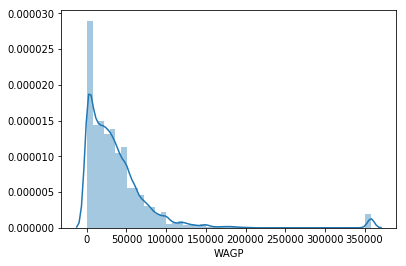

In [9]:
'''
WAGP 6
Wages or salary income past 12 months
bbbbbb .N/A (less than 15 years old)
000000 .None
000001..999999 .$1 to 999999 (Rounded and top-coded)
'''

sns.distplot(df['WAGP'])

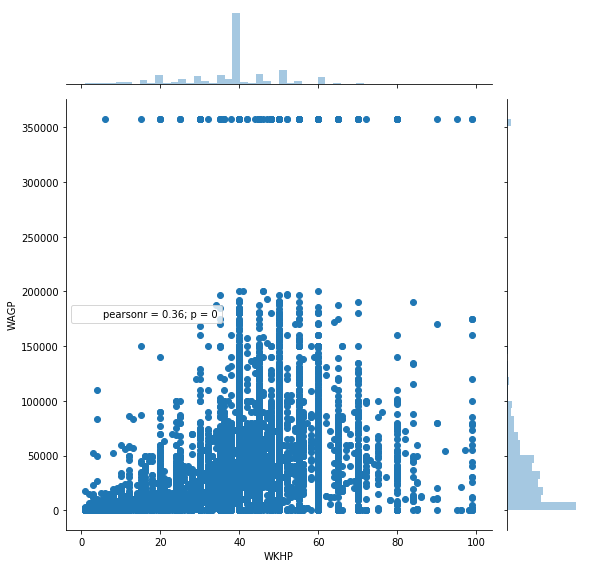

In [10]:
# we may think that wages relate to hours worked, so let's look at that relationship
'''
WKHP 2
Usual hours worked per week past 12 months
bb .N/A (less than 16 years old/did not work during the past 12
.months)
01..98 .1 to 98 usual hours
99 .99 or more usual hours
'''

sns.jointplot(x="WKHP", y="WAGP", data=df, size=8)

Notice how the data are lumpy.  It looks like people round when they report their values. 

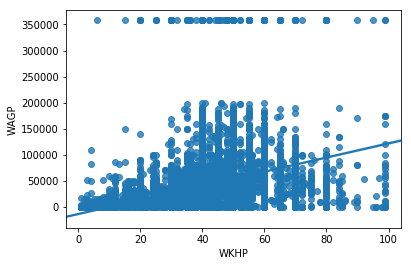

In [11]:
# we can also look at a regression plot, like we did before
sns.regplot(x="WKHP", y="WAGP", data=df)

### Estimating a model

OK, that's fine, we can do plots, but we want some actual numbers.  For this, we want to estimate what the model coefficients are. 

In [12]:
# This is a basic model estimation in statsmodels
# the dependent variable is on the left side of the ~
mod = smf.ols(formula='WAGP ~ WKHP', data=df) #response variable and explanatory 'WAGP ~ WKHP'
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     3273.
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:45:39   Log-Likelihood:            -2.6179e+05
No. Observations:               21558   AIC:                         5.236e+05
Df Residuals:                   21556   BIC:                         5.236e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.366e+04    959.204    -14.238      0.0

Notice a few things: 

1. Goodness of fit measures
2. Model coefficients and t-statistics
3. The model and results objects

In [13]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More experience -> higher wages? 

mod = smf.ols(formula='WAGP ~ WKHP + AGEP', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     2017.
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:46:39   Log-Likelihood:            -2.6147e+05
No. Observations:               21558   AIC:                         5.229e+05
Df Residuals:                   21555   BIC:                         5.230e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -3.38e+04   1227.379    -27.535      0.0

### Categorical variables

We may also want to include categorical variables.  We can include them by calculating a 'dummy' variable, which is 1 if the value is in a category, and zero otherwise.  

In [10]:
'''
SCHL 2
Educational attainment
bb .N/A (less than 3 years old)
01 .No schooling completed
02 .Nursery school, preschool 03 .Kindergarten
04 .Grade 1
05 .Grade 2
06 .Grade 3
07 .Grade 4
08 .Grade 5
09 .Grade 6
10 .Grade 7
11 .Grade 8
12 .Grade 9
13 .Grade 10
14 .Grade 11 15 .12th grade - no diploma
16 .Regular high school diploma
17 .GED or alternative credential
18 .Some college, but less than 1 year
19 .1 or more years of college credit, no degree
20 .Associate's degree
21 .Bachelor's degree
22 .Master's degree
23 .Professional degree beyond a bachelor's degree
24 .Doctorate degree
'''

# Is someone a college grad
df['college_grad'] = df['SCHL'].apply(lambda x : x>=20)

In [11]:
# note that I can wrap long strings with a \ character
mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + college_grad", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2001.
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:40:58   Log-Likelihood:            -2.6067e+05
No. Observations:               21558   AIC:                         5.213e+05
Df Residuals:                   21554   BIC:                         5.214e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3.617e+04 

Looks like a college degree is worth $23,000 per year...

What happens if we include both college and non-college in the same model? 

In [12]:
# not a college grad
df['not_college_grad'] = df['SCHL'].apply(lambda x : x<20)

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + college_grad \
                       + not_college_grad", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2001.
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:41:32   Log-Likelihood:            -2.6067e+05
No. Observations:               21558   AIC:                         5.213e+05
Df Residuals:                   21554   BIC:                         5.214e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

We get a warning, and very different results for that term.  This is an over-specified model, and the method cannot estimate the correct coefficients.  To avoid this, we always need to make sure that categorical variables leave one out.  This one that gets left out is known as the reference variable. 

In [13]:
# We can do all categories, minus one, for a variable by including it in a C() command

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + C(SCHL)", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     317.6
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:43:45   Log-Likelihood:            -2.6005e+05
No. Observations:               21558   AIC:                         5.201e+05
Df Residuals:                   21533   BIC:                         5.203e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.412e+04   4422.340     

In [14]:
# many of these are not significant, so let's drop some
def recode_school(schl): 
    if schl<=15: 
        return '15-No HS diploma'
    elif schl==16 or schl==17: 
        return '16-HS or GED'
    elif schl==18 or schl==19: 
        return '18-Some college'
    elif schl==20: 
        return '20-Associates degree'
    elif schl==21: 
        return '21-Bachelors degree'
    elif schl==22: 
        return '22-Masters degree'
    elif schl==23: 
        return '23-Prof grad degree'
    elif schl==24: 
        return '24-Doctorate degree'
    else: 
        return str(schl)

df['SCHL2'] = df['SCHL'].apply(recode_school)
df['SCHL2'].value_counts()

16-HS or GED            6466
18-Some college         5226
21-Bachelors degree     3564
20-Associates degree    1872
15-No HS diploma        1865
22-Masters degree       1768
23-Prof grad degree      532
24-Doctorate degree      265
Name: SCHL2, dtype: int64

In [15]:
# We can do all categories, minus one, for a variable by including it in a C() command

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + C(SCHL2)", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     844.7
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:44:45   Log-Likelihood:            -2.6006e+05
No. Observations:               21558   AIC:                         5.201e+05
Df Residuals:                   21548   BIC:                         5.202e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [16]:
df['PUMA'].head()

1      100
3     1706
8     1706
9     1400
10    1400
Name: PUMA, dtype: int64

In [17]:
# add sex 
'''
SEX 1
Sex
1 .Male
2 .Female
'''

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + C(SCHL2) \
                       + C(SEX)", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   WAGP   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     810.1
Date:                Thu, 05 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:45:48   Log-Likelihood:            -2.5987e+05
No. Observations:               21558   AIC:                         5.198e+05
Df Residuals:                   21547   BIC:                         5.199e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Confounding factors

It looks like there is a $11,000 penalty for being a woman.  Why is that?  

First, we want to make sure that we are measuring the effect of sex, and not the effect of something else that sex is correlated with.  For example, maybe we suspect that women earn less because they tend to work fewer hours or are younger.  Let's start by looking at the data categorically...

In [ ]:
# look at the average values
df[['SEX', 'WAGP', 'WKHP', 'AGEP']].groupby('SEX').mean()

Yes, this is true for hours worked at least, but it is not the whole story.  The total wage gap is $15,000.  That is made up of several components. 

Sometimes it is useful to look at pair-plots to see the relationships. 

In [ ]:
# for a select set of variables
sns.pairplot(df[['SEX', 'WAGP', 'WKHP', 'AGEP']])

In [ ]:
# if we were to leave out the hours worked, we would get a different coefficient on sex

mod = smf.ols(formula="WAGP \
                       ~ AGEP \
                       + C(SCHL2) \
                       + C(SEX)", 
              data=df)
res = mod.fit()
print(res.summary())

For this reason, regression provides an important tool to test the net effects of different factors.  If we wanted, we could also interact sex with the type of degree.  

In [ ]:
# we can also interact terms

df['AGE_WOMEN'] = df['AGEP'] * (df['SEX'] - 1)
df['AGE_MEN']   = df['AGEP'] * (2-df['SEX'])

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGE_MEN \
                       + AGE_WOMEN \
                       + C(SCHL2) \
                       + C(SEX)", 
              data=df)
res = mod.fit()
print(res.summary())

In [ ]:
# we can get the same thing, with a slightly different specification
# this tells us whether the AGEP and AGE_WOMEN coefficients are significantly different from each other

mod = smf.ols(formula="WAGP \
                       ~ WKHP \
                       + AGEP \
                       + AGE_WOMEN \
                       + C(SCHL2) \
                       + C(SEX)", 
              data=df)
res = mod.fit()
print(res.summary())

### Homework

1. Calculate the value of a Civil Engineering degree and a degree in Transportation Sciences And Technologies, relative to a college degree in general. 

2. Calculate the value of working in Architectural, Engineering, And Related Services versus wroking in transportation (anything starting in TRN).  

3. Calculate the wage difference between male and female civil engineers

4. Use these data to determine what you should expect your starting salary to be for a full-time job in your career of choice after you graduate.  These may be a useful observation point for negotiations.  Who can come up with the highest (defensible) value?  What other data could you use to make your case? 

### Bonus

Win your bracket next year with a data-driven March Madness!

https://canvas.harvard.edu/courses/12656/files/2822157/download?verifier...1